In [1]:
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
import scqubits as scq
import qutip as q

# Pulse shaping

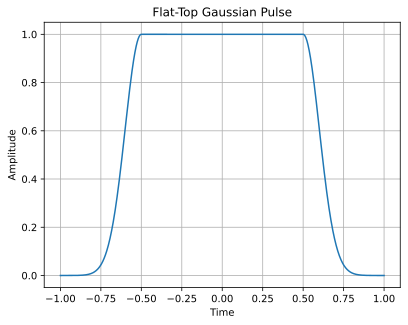

In [2]:
# Pulse
def flat_top_gaussian(t, A, sigma, T, flat_top_duration):
   
    # Calculate the edges of the flat-top region
    t1 = T - flat_top_duration / 2
    t2 = T + flat_top_duration / 2
    
    # Gaussian rise edge
    rise_edge = A * np.exp(-0.5 * ((t - t1) / sigma)**2)
    
    # Gaussian fall edge
    fall_edge = A * np.exp(-0.5 * ((t - t2) / sigma)**2)
    
    # Flat-top region
    flat_top = np.where((t >= t1) & (t <= t2), A, 0)
    
    # Combine edges and flat-top region
    pulse = np.maximum(rise_edge, flat_top)
    pulse = np.maximum(pulse, fall_edge)
    pulse = (pulse - np.amin(pulse))/(np.amax(pulse)- np.amin(pulse)) * A
    
    return pulse

# Parameters
A = 1.0               # Amplitude
sigma = 0.1           # Standard deviation of the Gaussian edges
T = 0.0               # Center of the pulse
flat_top_duration = 1  # Duration of the flat top part of the pulse
t = np.linspace(-1, 1, 1000)  # Time array

# Generate the pulse
pulse = flat_top_gaussian(t, A, sigma, T, flat_top_duration)

# Plot the pulse
plt.plot(t, pulse)
plt.title('Flat-Top Gaussian Pulse')
plt.xlabel('Time')
plt.ylabel('Amplitude')
plt.grid(True)
plt.show()

# Abstract model

Simple model just with two two-level systems

In [3]:
# transmon 1
tmon_dim = 2
h1 = q.Qobj(np.diag([0, 4.655]))
i1 = q.qeye(tmon_dim)
n1 = q.sigmax()
num1 = q.Qobj(np.diag(np.arange(tmon_dim)))

In [4]:
# transmon 2
tmon_dim = 2
h2 = q.Qobj(np.diag([0, 4.665]))
i2 = q.qeye(tmon_dim)
n2 = q.sigmax()
num2 = q.Qobj(np.diag(np.arange(tmon_dim)))

In [63]:
g_ZZ = -0.00001 # still add some ZZ
H1 = q.tensor(h1, i2)
H2 = q.tensor(i1, h2)
H_static = q.tensor(h1, i2) + q.tensor(i1, h2) + g_ZZ * q.tensor(num1, num2)
XX = q.tensor(n1, n2)
Num1 = q.tensor(num1, i2)
Num2 = q.tensor(i1, num2)

#pulse engineering
t_list = np.linspace(0, 231, int(150*201))
A_g = 0.002 
A_f2 = 0.01 
sigma = 14
g_pulse = flat_top_gaussian(t_list-t_list[-1]/2, A_g, sigma, 0, t_list[-1]/2*0.8)
f_pulse = -flat_top_gaussian(t_list-t_list[-1]/2, A_f2, sigma, 0, t_list[-1]/2*0.8)
# Note that in reality pulses will certainly be skewed

# Time-dependent sesolver
H = [2*np.pi*H_static, [2*np.pi*XX, q.Cubic_Spline(t_list[0], t_list[-1], g_pulse)],
     [2*np.pi*Num2, q.Cubic_Spline(t_list[0], t_list[-1], f_pulse)]]

In [64]:
psi0 = q.tensor(q.basis(tmon_dim, 1), q.basis(tmon_dim, 0))
result = q.sesolve(H, psi0, t_list, [Num1, Num2], options = q.Options(rtol = 1e-10, atol = 1e-10))

In [66]:
result = q.propagator(H, t_list, options = q.Options(rtol = 1e-10, atol = 1e-10))

In [67]:
def U_frame(t):
    return (-1j*2*np.pi*(H1+H2)*t).expm()
U_frame(t_list[-1]).dag() * result[-1]

Quantum object: dims = [[2, 2], [2, 2]], shape = (4, 4), type = oper, isherm = False
Qobj data =
[[ 9.99999950e-01+3.16412045e-04j  0.00000000e+00+0.00000000e+00j
   0.00000000e+00+0.00000000e+00j -4.04806156e-10+1.94812556e-10j]
 [ 0.00000000e+00+0.00000000e+00j  6.25580099e-02-4.39564819e-03j
  -9.62722713e-01-2.63120031e-01j  0.00000000e+00+0.00000000e+00j]
 [ 0.00000000e+00+0.00000000e+00j  1.09759051e-01+9.91977885e-01j
  -1.40981020e-02+6.11070394e-02j  0.00000000e+00+0.00000000e+00j]
 [-2.60863732e-10+3.65705842e-10j  0.00000000e+00+0.00000000e+00j
   0.00000000e+00+0.00000000e+00j -1.69958531e-01+9.85451215e-01j]]

(0.0, 1.0)

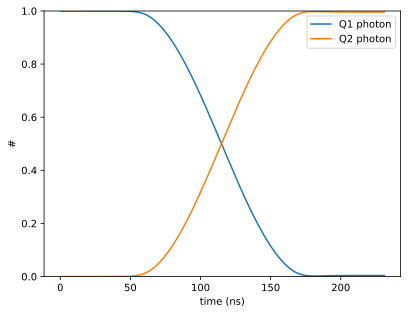

In [65]:
plt.plot(t_list, result.expect[0], label = 'Q1 photon')
plt.plot(t_list, result.expect[1], label = 'Q2 photon')
plt.legend()
plt.xlabel('time (ns)')
plt.ylabel('#')

plt.ylim(0,1)

Text(0, 0.5, 'MHz')

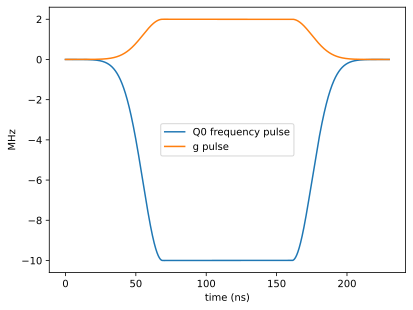

In [6]:
plt.plot(t_list, f_pulse*1000, label='Q0 frequency pulse')
plt.plot(t_list, g_pulse*1000, label='g pulse')
plt.legend()
plt.xlabel('time (ns)')
plt.ylabel('MHz')

# Phase identification

# scqubits setup